In [1]:
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import os
import torch
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from SNN import FeedForward, SiameseDataSet, SiameseModel, seed_everything
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
import random

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [3]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [4]:
X = MatrixData

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),Sample title (Paper),...,Use of milk or milk products (Yes/No/Sometimes),Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan),Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy
0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,ZSL-004,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy
1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,ZSL-007,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy
2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,ZSL-010,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy
3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,ZSL-011,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy
4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,ZSL-019,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy


In [6]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [7]:
SampleMeta['Healthy'].value_counts()

Healthy      2636
Unhealthy    1711
Name: Healthy, dtype: int64

In [8]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

In [9]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
OneHot = OneHotEncoder(sparse=False)
y = OneHot.fit_transform(y.reshape((y.shape[0], 1)))

In [11]:
y.shape

(4347, 2)

In [12]:
np.sum(y, axis=0)

array([1711., 2636.])

In [13]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# Define and Train Model

In [14]:
seed_everything(69)

In [15]:
MyFeedForward = FeedForward(20, [20, 20, 10, 10, 5])

In [16]:
MyFeedForward

FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=5, bias=True)
  )
)

In [17]:
MySNN = SiameseModel(MyFeedForward, predict_unknown = False, class_min_train=5, 
                     n_example_predict=30, learning_rate=1.0e-3, num_epochs = 10, batch_size = 10, rand_seed=69)

In [18]:
# list(MySNN.logistic.parameters()) + list(MySNN.model.parameters())

In [19]:
MyTrainer = Trainer(model = MySNN, scale_X = True, use_pca = True, n_components = 20)

In [20]:
MyTrainTester = TrainTester(MyTrainer, metrics.accuracy_score)

In [21]:
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, n_splits=n_splits)

In [22]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Training Encoder
#########################################
Epoch 1 of 10
__Training__
2021-03-09 02:57:35
MEAN LOSS: 0.7012450872421264
__Validation__
2021-03-09 02:57:40
MEAN LOSS: 0.6930045293967645
#########################################
Epoch 2 of 10
__Training__
2021-03-09 02:57:40
MEAN LOSS: 0.6920157093763352
__Validation__
2021-03-09 02:57:45
MEAN LOSS: 0.692477095674331
#########################################
Epoch 3 of 10
__Training__
2021-03-09 02:57:45
MEAN LOSS: 0.6907237740278244
__Validation__
2021-03-09 02:57:50
MEAN LOSS: 0.6936989685203662
#########################################
Epoch 4 of 10
__Training__
2021-03-09 02:57:50
MEAN LOSS: 0.6883369501113892
__Validation__
2021-03-09 02:57:55
MEAN LOSS: 0.6897041895280112
#########################################
Epoch 5 of 10
__Training__
2021-03-09 02:57:55
MEAN LOSS: 0.6817492584466934
__Validation__
2021-03-09 02:58:00
MEAN LOSS: 0.6864007314940384
#######################################

MEAN LOSS: 0.6917292913913727
__Validation__
2021-03-09 03:01:28
MEAN LOSS: 0.6904541205758988
#########################################
Epoch 4 of 10
__Training__
2021-03-09 03:01:29
MEAN LOSS: 0.6875691605806351
__Validation__
2021-03-09 03:01:33
MEAN LOSS: 0.6887893023842847
#########################################
Epoch 5 of 10
__Training__
2021-03-09 03:01:34
MEAN LOSS: 0.6824566561698914
__Validation__
2021-03-09 03:01:38
MEAN LOSS: 0.690430286228925
#########################################
Epoch 6 of 10
__Training__
2021-03-09 03:01:39
MEAN LOSS: 0.6804280130147934
__Validation__
2021-03-09 03:01:43
MEAN LOSS: 0.6895450772088889
#########################################
Epoch 7 of 10
__Training__
2021-03-09 03:01:44
MEAN LOSS: 0.679330963397026
__Validation__
2021-03-09 03:01:48
MEAN LOSS: 0.6893356928516357
#########################################
Epoch 8 of 10
__Training__
2021-03-09 03:01:49
MEAN LOSS: 0.6783127366542816
__Validation__
2021-03-09 03:01:53
MEAN LOSS: 0.6893

In [23]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.719873,train
1,0.713834,train
2,0.687949,train
3,0.724763,train
4,0.707506,train
0,0.711494,test
1,0.678161,test
2,0.668966,test
3,0.675862,test
4,0.671264,test


<AxesSubplot:xlabel='stage', ylabel='score'>

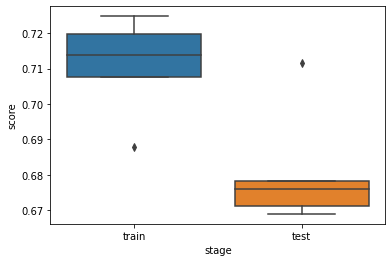

In [24]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

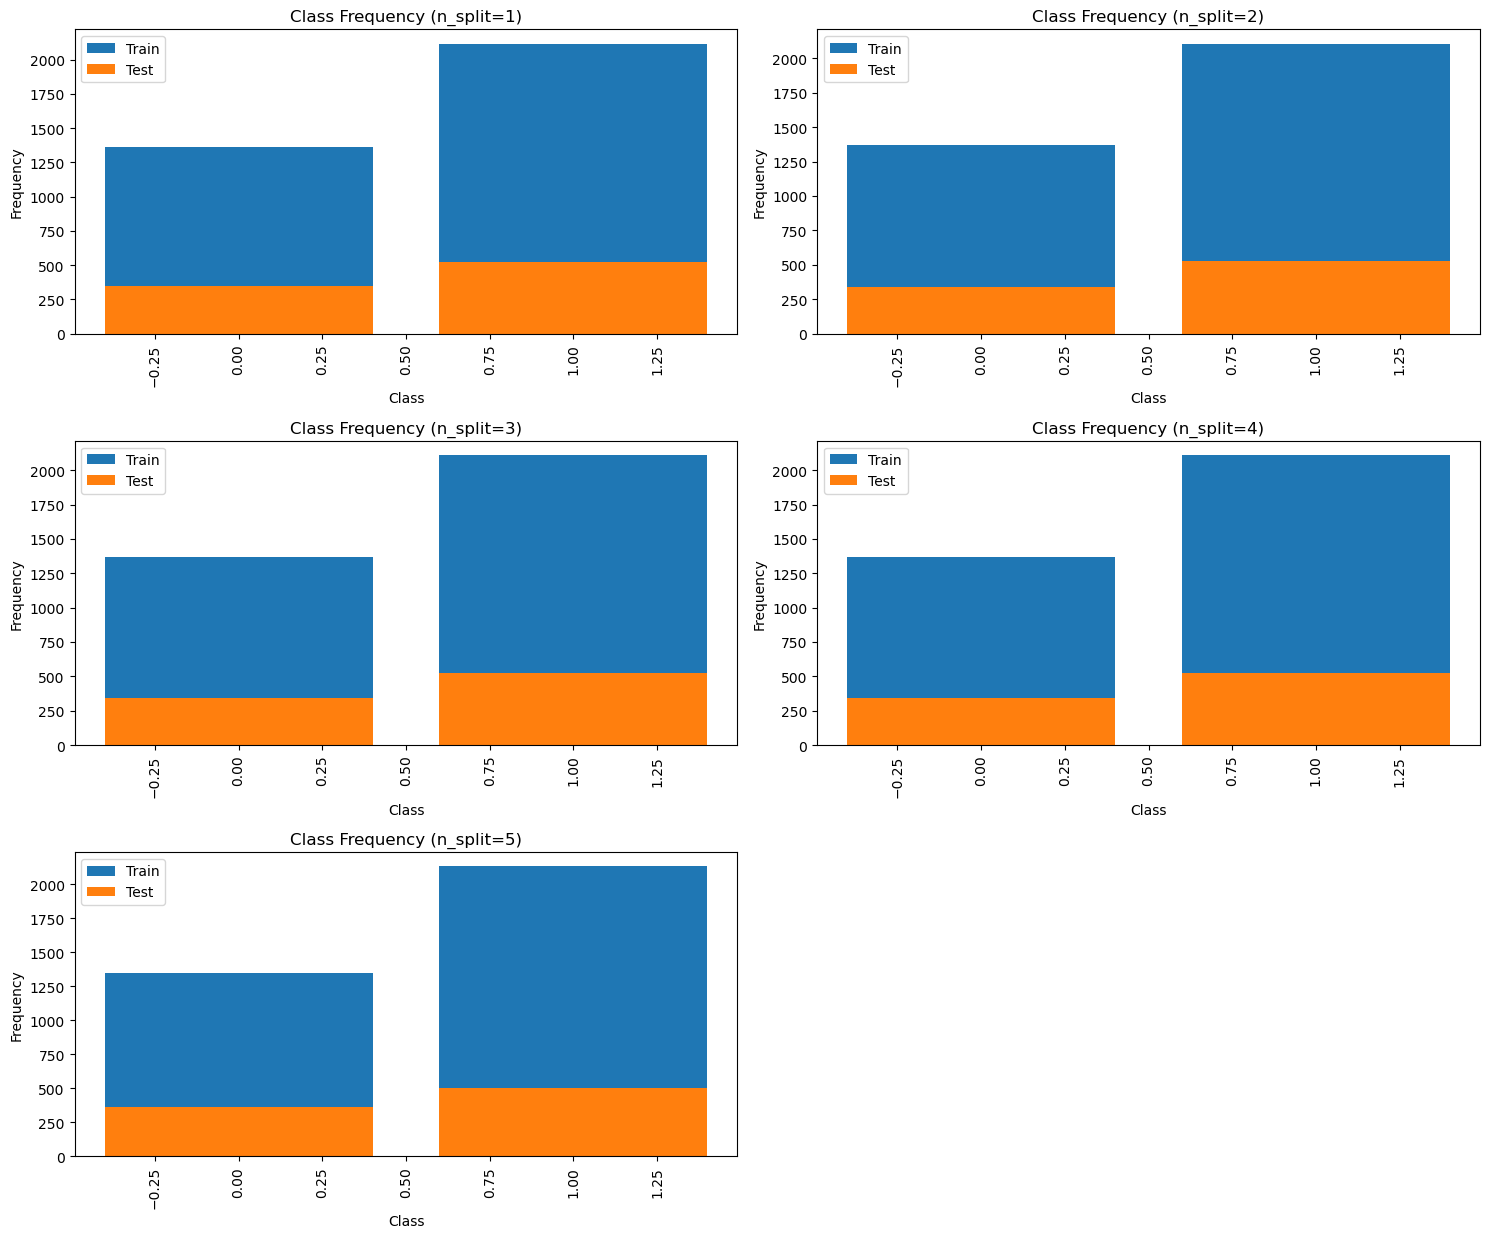

In [25]:
MyMultiTrainTester.plot_class_freq(normalize=True)

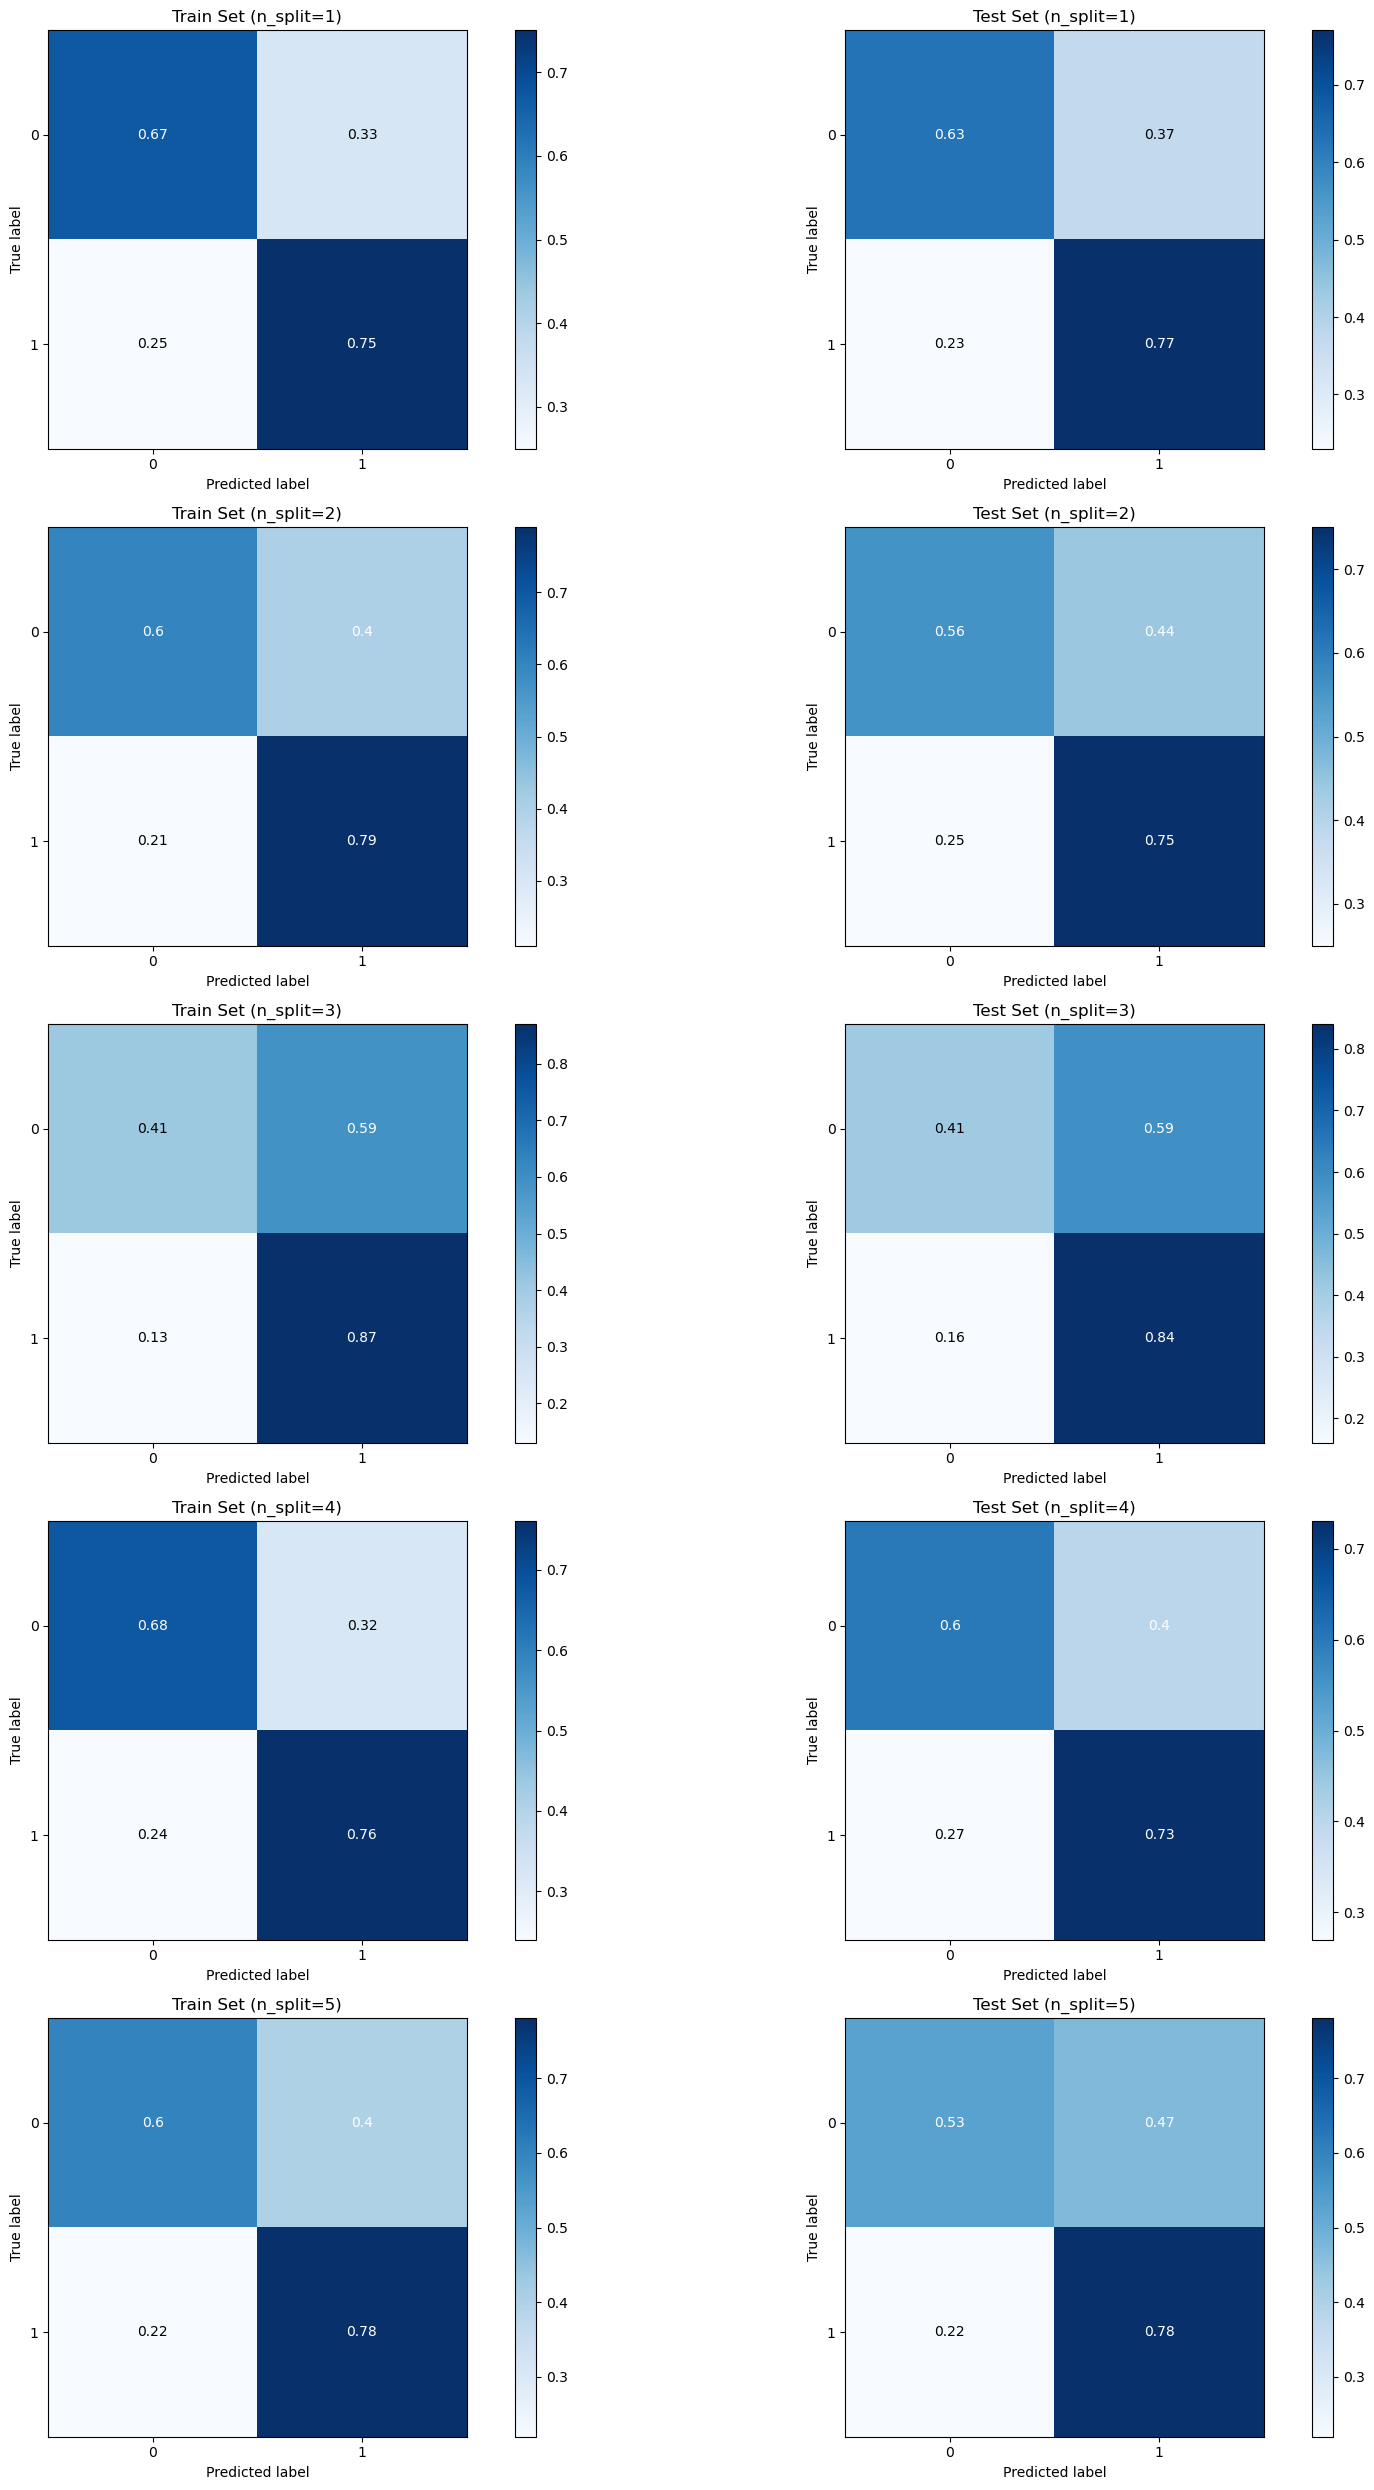

In [26]:
MyMultiTrainTester.plot_confusion(normalize=True)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


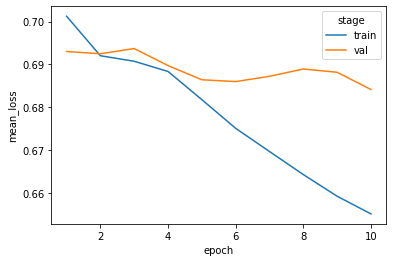

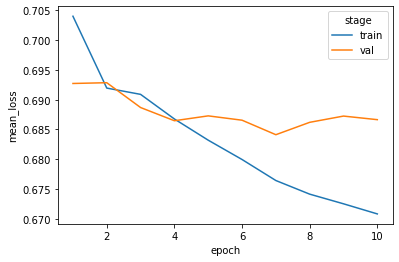

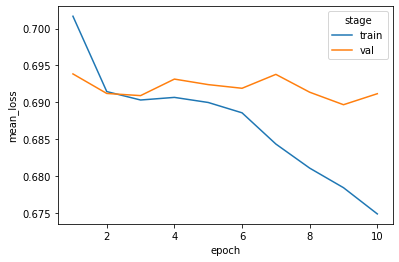

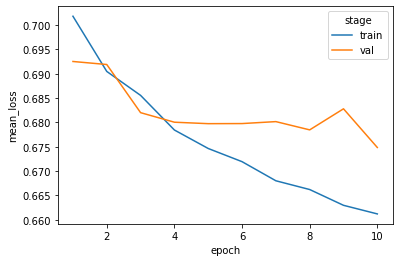

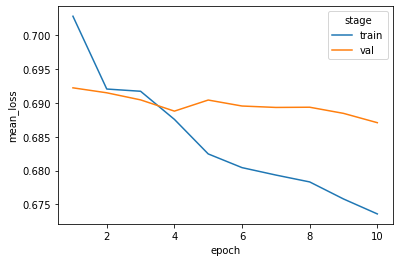

In [27]:
for i, trainer in enumerate(MyMultiTrainTester.TrainerList):
    plt.figure(i)
    print(sns.lineplot(data=trainer.model.TrainStats, x='epoch', y='mean_loss', hue = 'stage'))

### Examine Data In Encoded Space

In [28]:
Trainer_use = MyMultiTrainTester.TrainerList[0]

In [29]:
X_transform = Trainer_use.transform_X(X)

In [30]:
X_encoded = Trainer_use.model.model.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [31]:
# X_encoded = MyFeedForward.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [32]:
X_encoded.shape

(4347, 5)

In [33]:
y_label = Trainer_use.model.one_hot.inverse_transform(y).astype('str')
y_pred = Trainer_use.model.predict(X_transform)
y_pred = Trainer_use.model.one_hot.inverse_transform(y_pred).astype('str')

In [34]:
X_enc_df = pd.DataFrame(X_encoded, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
X_enc_df['y'] = y_label
X_enc_df['y_pred'] = y_pred

In [35]:
X_enc_df

,X1,X2,X3,X4,X5,y,y_pred
0,0.007528,0.698665,0.000000,0.0,0.000000,0,0
1,0.007528,0.698665,0.000000,0.0,0.000000,0,0
2,0.007528,0.698665,0.000000,0.0,0.000000,0,0
3,0.007528,0.698665,0.000000,0.0,0.000000,0,0
4,0.776066,0.333429,0.000000,0.0,0.000000,0,1
...,...,...,...,...,...,...,...
4342,0.007528,0.698665,0.000000,0.0,0.000000,0,0
4343,1.746646,0.000000,0.000000,0.0,1.158193,0,1
4344,1.407199,0.000000,0.293177,0.0,0.000000,0,1
4345,0.692959,0.388531,0.000000,0.0,0.000000,0,1


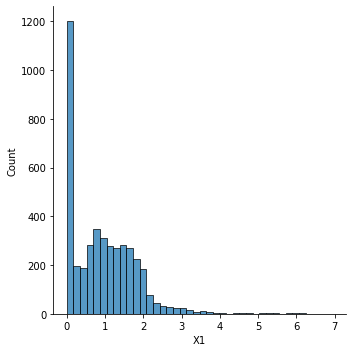

In [36]:
sns.displot(X_enc_df['X1'])

In [37]:
def do_plot(df, x, y, hue):
    if x in df.columns and y in df.columns and hue in df.columns:
        sns.scatterplot(data=df, x=x, y=y, hue = hue)

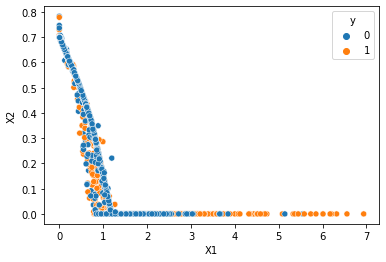

In [38]:
do_plot(X_enc_df, 'X1', 'X2', 'y')

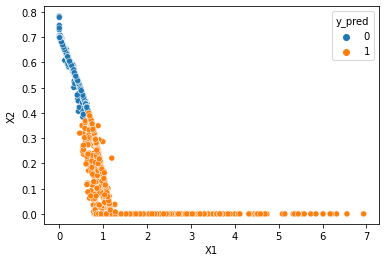

In [39]:
do_plot(X_enc_df, 'X1', 'X2', 'y_pred')

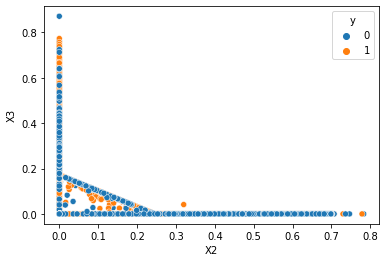

In [40]:
do_plot(X_enc_df, 'X2', 'X3', 'y')

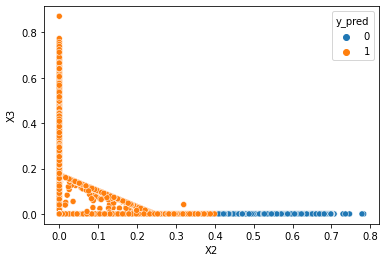

In [41]:
do_plot(X_enc_df, 'X2', 'X3', 'y_pred')

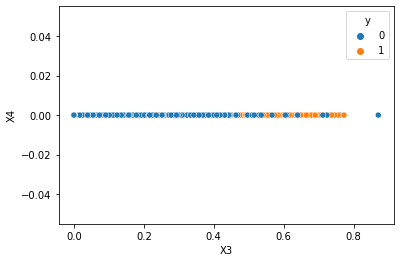

In [42]:
do_plot(X_enc_df, 'X3', 'X4', 'y')